In [1]:
#coding:utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import seaborn as sns
import os 

def listdir1(path):
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        if os.path.isdir(file_path):  
            listdir1(file_path)  
        else:
            if os.path.splitext(file_path)[1]=='.npy':
                print file_path
def listdir(path, list_name):  #传入存储的list
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        if os.path.isdir(file_path):
            listdir(file_path, list_name)  
        else: 
            if os.path.splitext(file_path)[1]=='.npy':
                list_name.append(file_path)
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    return 96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)
    return 1.0/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (c=G=1 unit))'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt(m_1+m_2)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70




#consts setting
sivalue=1.0
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=years*sivalue




#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]*1e70
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
print Aval,Aerr
sys.stdout.flush()


# In[78]:


# sciode
def df_dtode(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    result=96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
    return result

64376551.0817 4234.03572007


/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [2]:
m=[3.69400000e+01,2.40000000e-01,3.10985939e+00]

mcv=m[0]*m_sun
smrv=m[1]
sv=solvem(mcv,smrv)
m1v=sv[0]
m2v=sv[1]
phic=m[2]
n2=10000
ts=np.linspace(0,t_scale,n2)
yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
ftv=sci_interpolate.interp1d(ts,yf.T[0])
fr=ftv(ts)
phiv1=np.zeros(n2)
i=0
while i<n2:
    phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
    i=i+1
phiv=sci_interpolate.interp1d(ts,phiv1)

rs=np.zeros(n2)
rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])

for i in range(1,n2,1):
    rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])

rv=sci_interpolate.interp1d(ts,rs)

t_scalev=ts[n2-1]
t=np.linspace(0,t_scalev,num=Ng)
hv=m1v*m2v/rv(t)*np.cos(phiv(t))/1e70
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(hv)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]*1e70
hvacr=sci_interpolate.interp1d(xs,hfvac2)
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
Bval=np.sqrt(B[0])
Berr=0.5/Bval*B[1]
print Bval,Berr
sys.stdout.flush()
AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
ff=abs(AB[0]/Aval/Bval)
err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
print ff,err

716235277.512 198240.520681
0.984880356842 0.000388118186551


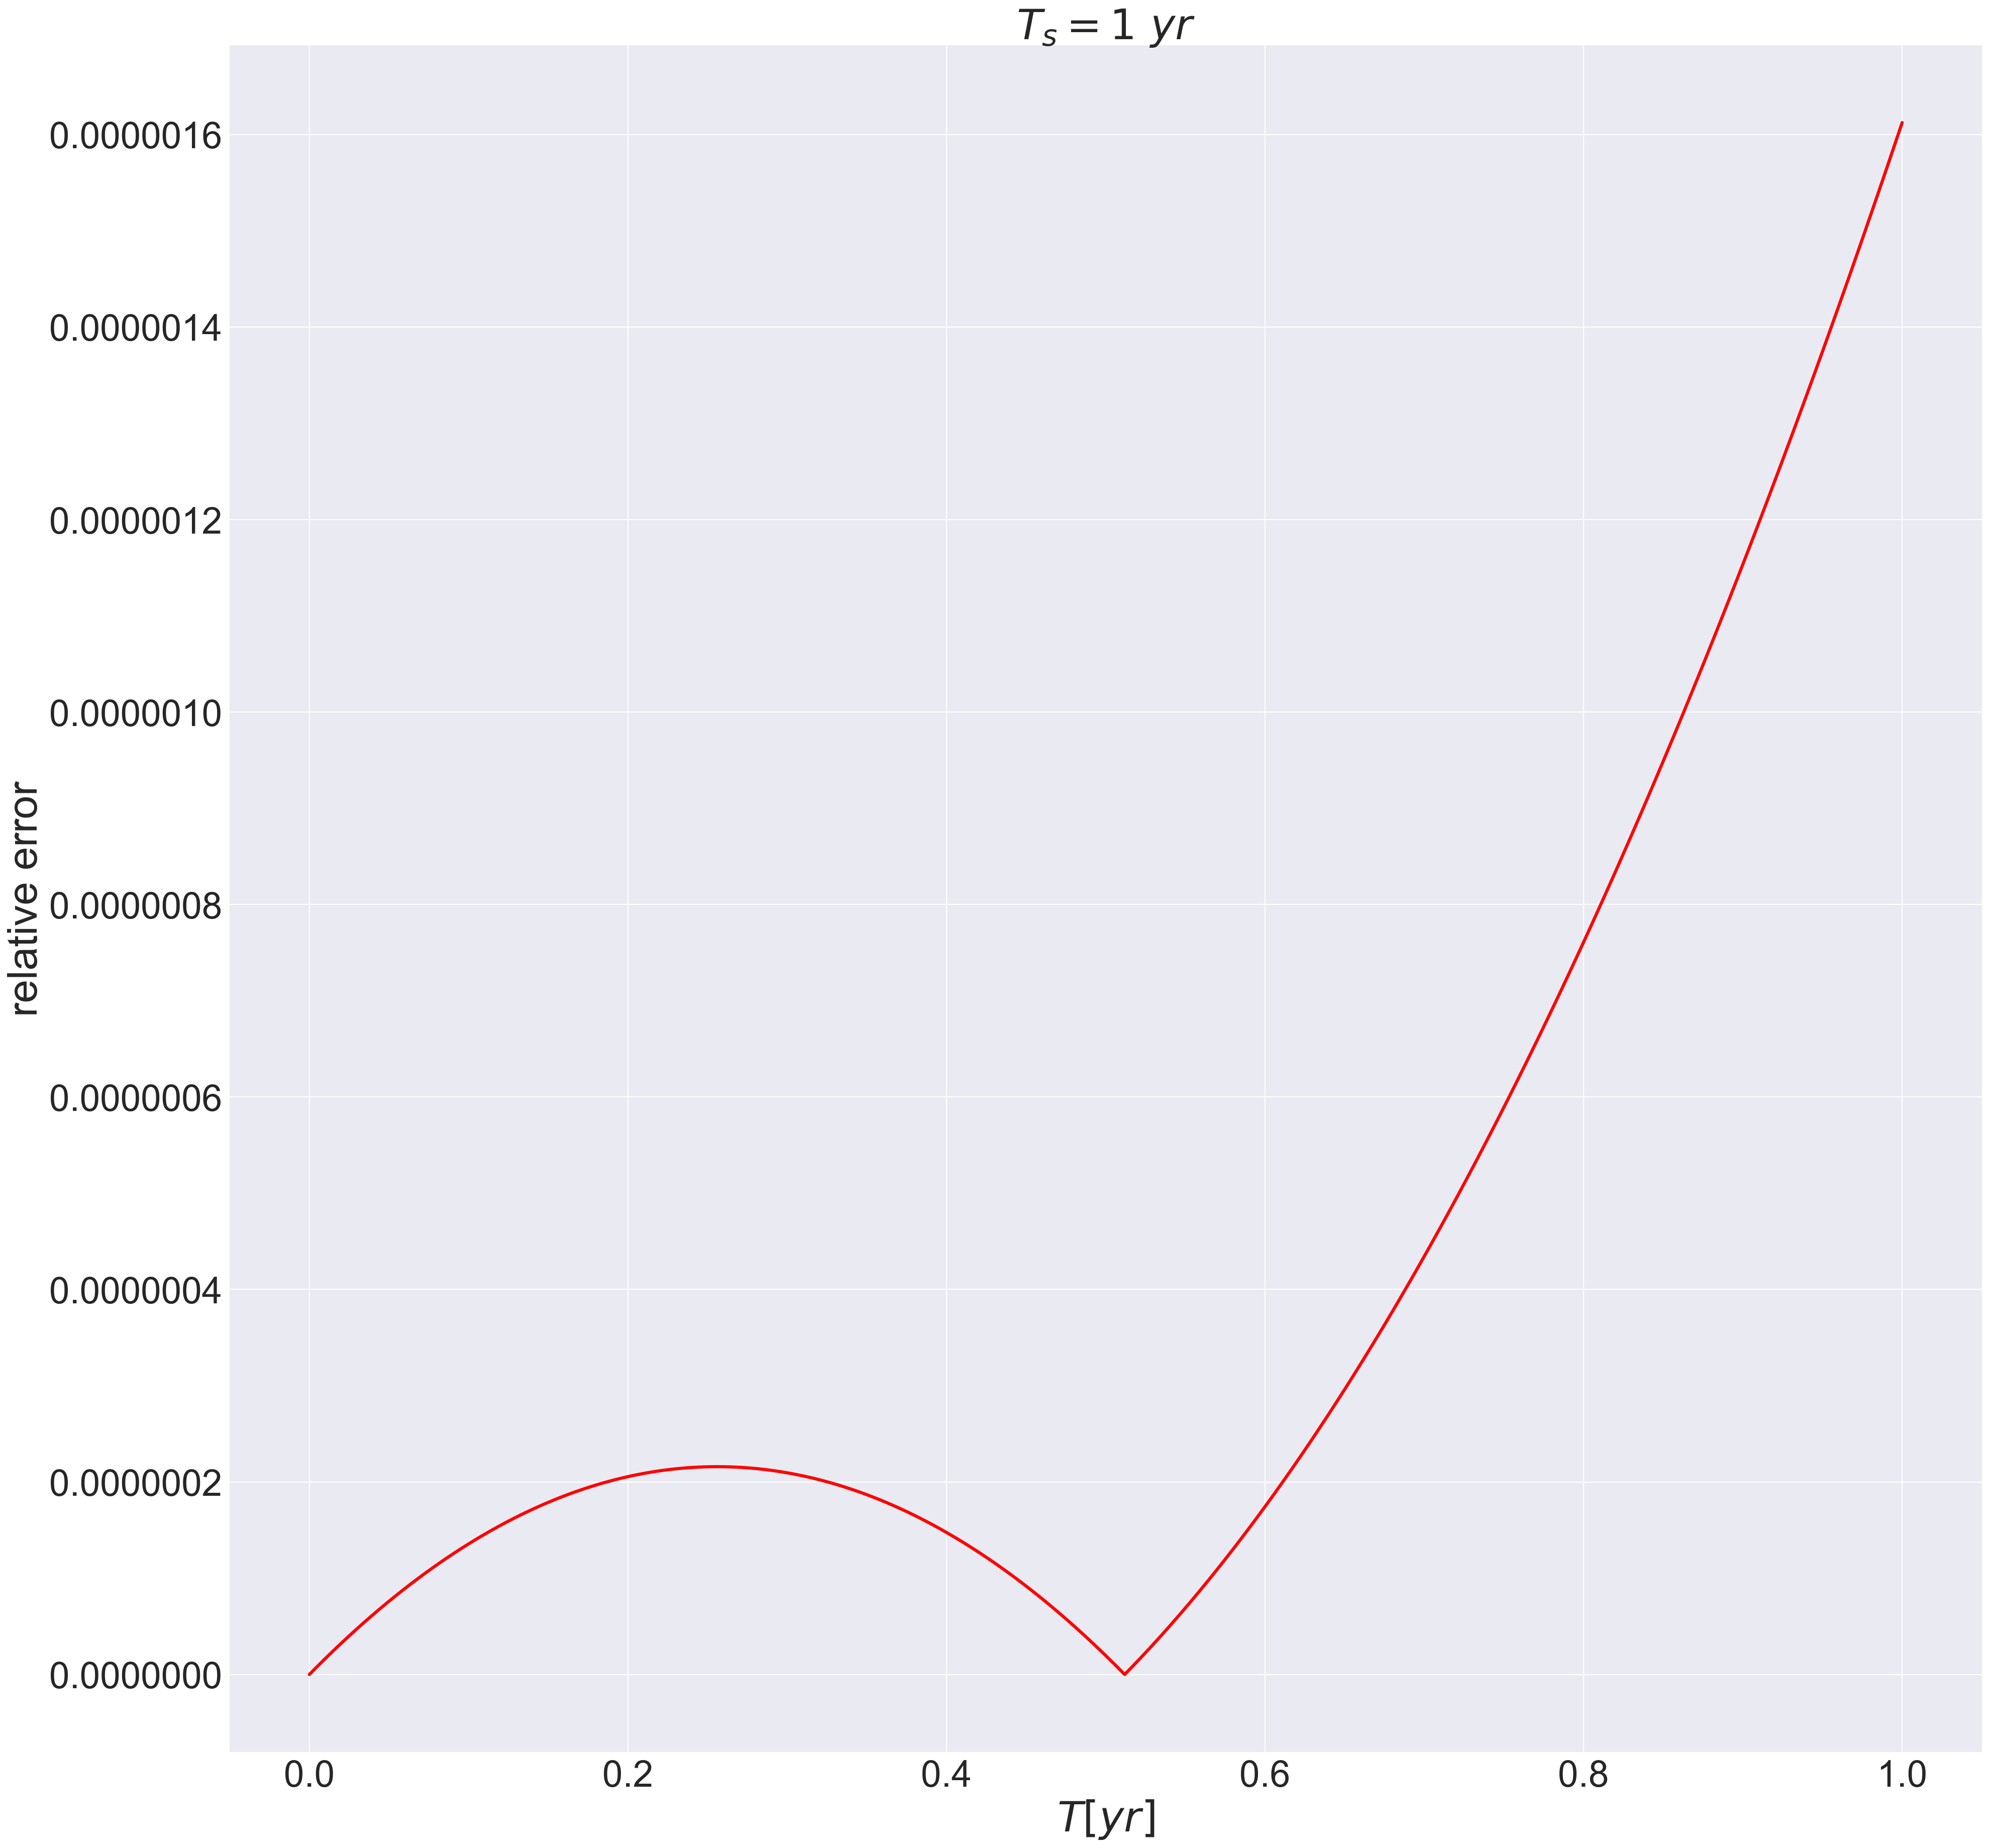

In [22]:
import matplotlib.pyplot as plt
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
tdomin=np.linspace(0,t_scale,10000)
fgas=freq_tgas(tdomin,m_1g,m_2g,t_gas,t_0g)
fvac=ftv(tdomin)
err=abs(fvac-fgas)/fvac
plt.clf()
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.title(r'$T_s=1\ yr$',fontsize=40)
plt.ylabel('relative error',fontsize=40)
plt.xlabel('$T[yr]$',fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.plot(tdomin/years,err,color='red',linewidth=3.0)
plt.show()

In [ ]:
[3.69400000e+01,2.40000000e-01,3.10985939e+00]

In [23]:
m_sun

4.9270380555784728e-06

In [24]:
ms=1.9891e30

In [25]:
mc=8.7*ms

In [40]:
A=np.power(sciconsts.G*mc,5.0/3)/8/sciconsts.c/sciconsts.c/sciconsts.c/np.power(sciconsts.pi,4.0/3)
A

128191787.73021704

In [ ]:
sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005

In [ ]:
sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005

In [70]:
def heff(T):
    figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
    ffgas=freq_tgas(T,m_1g,m_2g,t_gas,t_0g)
    int1=sci_integrate.quad(lambda x:np.power(x,-7.0/3)*20/3/S_n_lisa(x),figas,ffgas,limit=2500,epsrel=0.005)
    #print int1
    return 0.937*np.sqrt(A)/8*np.sqrt(int1[0])/sciconsts.parsec/1e6

In [51]:
heff(3*years)

(3.944491344362386e+41, 4.379265110945758e+27)


26.991353585195828

3.26379772476366

In [55]:
def listdir1(path):
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        if os.path.isdir(file_path):  
            listdir1(file_path)  
        else:
            if os.path.splitext(file_path)[1]=='.npy':
                print file_path
def listdir(path, list_name):  #传入存储的list
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        if os.path.isdir(file_path):
            listdir(file_path, list_name)  
        else: 
            if os.path.splitext(file_path)[1]=='.npy':
                list_name.append(file_path)

filename1='/Users/shyn/Desktop/shenzhefeng/allcol/'
max1=[]
for file in os.listdir(filename1):  
    file_path = os.path.join(filename1, file)  
    if os.path.isdir(file_path):  
        nam1=[]
        listdir(file_path,nam1)
        g=np.array(nam1)
        data=np.load(g[0])
        for i in g[1:g.size]:
            a=np.load(i)
            data=np.concatenate((data,a))
        a=data[np.where(data.T[0]==data.T[0].max())[0]]
        nu=float(file)
        #max1.append([a[0][0],a[0][2],a[0][3],a[0][4],nu])
        max1.append([a[0][0],nu])
max1

[[1.0006305838922189, 0.625],
 [0.94341220237539147, 1.625],
 [0.87591885890212995, 2.75],
 [0.79298833919948652, 3.5],
 [0.9617023688672256, 1.25],
 [1.0000919586781492, 0.25],
 [1.0003537012676313, 0.125],
 [0.97302716165096426, 1.375],
 [1.0000621555238438, 0.375],
 [0.99878172825346234, 1.125],
 [0.76390103494583916, 3.25],
 [0.83742113659398476, 3.0],
 [0.83051720171907895, 2.25],
 [0.96184930509272804, 1.5],
 [0.87135996742304944, 1.875],
 [0.99952887017849323, 0.875],
 [0.89571048617635407, 1.75],
 [0.99994345128371853, 0.75],
 [0.82125298768928001, 2.5]]

In [66]:
a=[]
b=[]
plt.clf()
for i in max1:
    a.append(tuple(i))
dt=[('ffmax',float),('time',float)]
a=np.array(a,dtype=dt)
a.sort(order='time')
for i in a:
    b.append(list(i))
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.ylabel('FF',fontsize=25)
plt.xlabel(r'$T_s[yr]$',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
c=[]
np.array(b).T[1]
    

array([ 0.125,  0.25 ,  0.375,  0.625,  0.75 ,  0.875,  1.125,  1.25 ,
        1.375,  1.5  ,  1.625,  1.75 ,  1.875,  2.25 ,  2.5  ,  2.75 ,
        3.   ,  3.25 ,  3.5  ])

In [73]:
x=[]
for i in np.array(b).T[1]:
    x.append(heff(i*years))

In [75]:
np.array(x)

array([  5.47619579,   7.74655811,   9.4900659 ,  12.25810186,
        13.43162803,  14.511652  ,  16.46336815,  17.35850148,
        18.21056271,  19.0253404 ,  19.80743665,  20.56058185,
        21.28784958,  23.33816674,  24.61359305,  25.82860068,
        26.99135359,  28.10834078,  29.1848208 ])

In [6]:
2.0*sciconsts.G*12*1.9891e30/sciconsts.c/sciconsts.c/6.955e8

5.0970715146216905e-05

In [4]:
sciconsts.c

299792458.0